In [1]:
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import copy
import mypyslha as pyslha
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    return levelPts

## Get SModelS Output and Cross-sections

In [9]:
rValues = []
allAna = []
bestAna = []
for fname in glob.glob('../data/smodels_output_BM1/*.py'):
    slhafile = os.path.basename(fname).replace('.py','')
    slhadata = pyslha.readSLHAFile(os.path.join('../data/slha_BM1/',slhafile))
    with open(fname,'r') as f:
        smodelsOutput = eval(f.read().replace("smodelsOutput = ",""),{'nan' : np.nan})    
    
    if not 'ExptRes' in smodelsOutput or not smodelsOutput['ExptRes']:
        continue
        bestR = 0.
    else:
        allAna += [res['AnalysisID'] for res in smodelsOutput['ExptRes']]
        bestR = max([res['r'] for res in smodelsOutput['ExptRes']])
        bestAna += [res['AnalysisID'] for res in smodelsOutput['ExptRes'] if res['r'] == bestR]
    mDM = slhadata.blocks['MASS'][5000522]
    mChi1 = slhadata.blocks['MASS'][5000521]
    rValues.append([mChi1,mChi1-mDM,bestR])
#     rValues.append([mLLP,lambLLP,bestR])

In [10]:
rValues = np.array(rValues)
bestAna = sorted(list(set(bestAna)))
allAna = sorted(list(set(allAna)))
bestAna,allAna

(['ATLAS-SUSY-2018-04'], ['ATLAS-SUSY-2018-04'])

In [11]:
cMistag = 0.25 # efficiency for mistagging a c-jet as a b-jet
#Assume that only events with no b-tagged jets are accepted (there are two c-jets/event):
acc = (1-cMistag)**2 
kfactor = 1.2
excCurve = np.array(getContour(rValues[:,0],rValues[:,1],kfactor*acc*rValues[:,2],levels=[1.])[1.][0])
excCurve[:,1] = excCurve[:,1]
# excCurve = np.append(excCurve,[excCurve[0]],axis=0) #Make sure curve closes

/home/lessa/.local/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


KeyError: 1.0

## Plot Curves

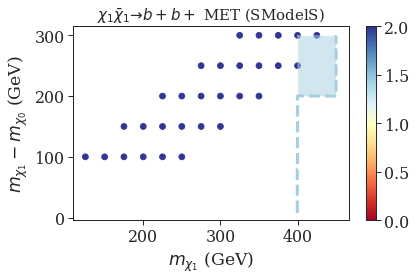

In [12]:
cp = plt.scatter(rValues[:,0],rValues[:,1],c=rValues[:,2],s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
plt.plot(excCurve[:,0],excCurve[:,1],label='Exclusion',linewidth=3,linestyle='--')
plt.fill_between(excCurve[:,0],excCurve[:,1],excCurve[:,1].max(),alpha=0.5)
cb = plt.colorbar(cp)
# plt.yscale('log')
plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
# plt.xlim(400.,1000.)
# plt.ylim(0,150.)
# plt.legend()
plt.tight_layout()
plt.title(r"$\chi_1 \bar{\chi}_1 \to b + b + $ MET (SModelS)",fontsize=15)
plt.tight_layout()
# plt.savefig('T2bb_exclusion_BM2.pdf')
plt.show()

In [11]:
np.savetxt('T2bb_exclusion_BM1.txt',excCurve,delimiter=',',header="mchi1 (GeV), mchi1-mchi0 (GeV)")